In [1]:
from attrdict import AttrDict
import numpy as np
import pandas as pd
from scipy.stats import gmean
from deepsense import neptune
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from src import pipeline_config  as cfg
from src.pipelines import PIPELINES
from src.utils import init_logger, read_params, set_seed, create_submission, verify_submission, calculate_rank

neptune: Executing in Offline Mode.
neptune: Executing in Offline Mode.


In [2]:
ctx = neptune.Context()
params = read_params(ctx, fallback_file='neptune.yaml')

def _read_data(dev_mode, read_train=True, read_test=False):
    if dev_mode:
        nrows = cfg.DEV_SAMPLE_SIZE
    else:
        nrows = None

    raw_data = {}

    if read_train:
        raw_data['application_train'] = pd.read_csv(params.train_filepath, nrows=nrows)

    if read_test:
        raw_data['application_test'] = pd.read_csv(params.test_filepath, nrows=nrows)

    raw_data['bureau'] = pd.read_csv(params.bureau_filepath, nrows=nrows)
    raw_data['credit_card_balance'] = pd.read_csv(params.credit_card_balance_filepath, nrows=nrows)
    raw_data['installments_payments'] = pd.read_csv(params.installments_payments_filepath, nrows=nrows)
    raw_data['pos_cash_balance'] = pd.read_csv(params.POS_CASH_balance_filepath, nrows=nrows)
    raw_data['previous_application'] = pd.read_csv(params.previous_application_filepath, nrows=nrows)
    raw_data['bureau_balance'] = pd.read_csv(params.bureau_balance_filepath, nrows=nrows)

    return AttrDict(raw_data)

neptune: Executing in Offline Mode.


# Train the model

In [47]:
dev_mode = False

tables = _read_data(dev_mode, read_train=True, read_test=False)


train_data_split, valid_data_split = train_test_split(tables.application_train,
                                                      test_size=params.validation_size,
                                                      random_state=cfg.RANDOM_SEED,
                                                      shuffle=params.shuffle)

train_dic = {'application': {'X': train_data_split.drop(cfg.TARGET_COLUMNS, axis=1),
                              'y': train_data_split[cfg.TARGET_COLUMNS].values.reshape(-1),
                              'X_valid': valid_data_split.drop(cfg.TARGET_COLUMNS, axis=1),
                              'y_valid': valid_data_split[cfg.TARGET_COLUMNS].values.reshape(-1)
                              },
              'bureau_balance': {'X': tables.bureau_balance},
              'bureau': {'X': tables.bureau},
              'credit_card_balance': {'X': tables.credit_card_balance},
              'installments_payments': {'X': tables.installments_payments},
              'pos_cash_balance': {'X': tables.pos_cash_balance},
              'previous_application': {'X': tables.previous_application},
              }

val_y_true = valid_data_split[cfg.TARGET_COLUMNS].values
val_dic = {'application': {'X': valid_data_split.drop(cfg.TARGET_COLUMNS, axis=1),
                                 'y': None,
                                 },
                 'bureau_balance': {'X': tables.bureau_balance},
                 'bureau': {'X': tables.bureau},
                 'credit_card_balance': {'X': tables.credit_card_balance},
                 'installments_payments': {'X': tables.installments_payments},
                 'pos_cash_balance': {'X': tables.pos_cash_balance},
                 'previous_application': {'X': tables.previous_application},
                 }

In [34]:

pipeline = PIPELINES['lightGBM'](config=cfg.SOLUTION_CONFIG, train_mode=True)
pipeline.clean_cache()
train_out = pipeline.fit_transform(train_dic)
pipeline.clean_cache()

2020-05-07 19:45:39 steppy >>> initializing Step application_cleaning...
2020-05-07 19:45:39 steppy >>> initializing experiment directories under .\WORKDIR
2020-05-07 19:45:39 steppy >>> done: initializing experiment directories
2020-05-07 19:45:39 steppy >>> Step application_cleaning initialized
2020-05-07 19:45:39 steppy >>> initializing Step application_cleaning_valid...
2020-05-07 19:45:39 steppy >>> initializing experiment directories under .\WORKDIR
2020-05-07 19:45:39 steppy >>> done: initializing experiment directories
2020-05-07 19:45:39 steppy >>> Step application_cleaning_valid initialized
2020-05-07 19:45:39 steppy >>> initializing Step application_hand_crafted...
2020-05-07 19:45:39 steppy >>> initializing experiment directories under .\WORKDIR
2020-05-07 19:45:39 steppy >>> done: initializing experiment directories
2020-05-07 19:45:39 steppy >>> Step application_hand_crafted initialized
2020-05-07 19:45:39 steppy >>> initializing Step application_hand_crafted_valid...
202

C:\Anaconda3\envs\responsible_data\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
E:\Robbie\School\responsible_data\open-solution-home-credit\src\feature_extraction.py:306: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: x.AMT_BALANCE.max() / x.AMT_CREDIT_LIMIT_ACTUAL.max()).reset_index()[0]
E:\Robbie\School\responsible_data\open-solution-home-credit\src\feature_extraction.py:306: RuntimeWarning: divide by zero encountered in double_scalars
  lambda x: x.AMT_BALANCE.max() / x.AMT_CREDIT_LIMIT_ACTUAL.max()).reset_index()[0]
C:\Anaconda3\envs\responsible_data\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
train_data = train_out['data']
train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(0)
model = train_out['estimator']
train_y_pred = train_out['prediction']


In [50]:
pipeline = PIPELINES['lightGBM'](config=cfg.SOLUTION_CONFIG, train_mode=False)
pipeline.clean_cache()
val_out = pipeline.transform(val_dic)
pipeline.clean_cache()


2020-05-09 10:34:34 steppy >>> initializing Step application_cleaning...
2020-05-09 10:34:34 steppy >>> initializing experiment directories under .\WORKDIR
2020-05-09 10:34:34 steppy >>> done: initializing experiment directories
2020-05-09 10:34:34 steppy >>> Step application_cleaning initialized
2020-05-09 10:34:34 steppy >>> initializing Step application_hand_crafted...
2020-05-09 10:34:34 steppy >>> initializing experiment directories under .\WORKDIR
2020-05-09 10:34:34 steppy >>> done: initializing experiment directories
2020-05-09 10:34:34 steppy >>> Step application_hand_crafted initialized
2020-05-09 10:34:34 steppy >>> initializing Step bureau_cleaning...
2020-05-09 10:34:34 steppy >>> initializing experiment directories under .\WORKDIR
2020-05-09 10:34:34 steppy >>> done: initializing experiment directories
2020-05-09 10:34:34 steppy >>> Step bureau_cleaning initialized
2020-05-09 10:34:34 steppy >>> initializing Step bureau_hand_crafted...
2020-05-09 10:34:34 steppy >>> initi

C:\Anaconda3\envs\responsible_data\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [53]:
val_data = val_out['data']
val_data = val_data.replace([np.inf, -np.inf], np.nan).fillna(0)
model = val_out['estimator']
val_y_pred = val_out['prediction']

In [54]:
y_true = val_y_true
y_pred = val_y_pred
data = val_data

print(data.shape)
print(roc_auc_score(y_true, y_pred))

(61503, 371)
0.7832379015452011


In [55]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(data.values,
                                                   feature_names=model.feature_name(),
                                                   mode='regression')


In [59]:
i = 10
exp = explainer.explain_instance(data.loc[i].values, model.predict, num_features=5)


In [64]:
exp.as_list()

[('external_sources_min <= 0.25', 0.01703065033298825),
 ('external_sources_weighted > 3.96', -0.01351334220582137),
 ('0.46 < EXT_SOURCE_3 <= 0.63', -0.011139784795302829),
 ('bureau_SK_ID_CURR_mean_AMT_CREDIT_MAX_OVERDUE <= 0.00',
  -0.010236867714013862),
 ('AMT_ANNUITY <= 16573.50', -0.009571895684291341)]

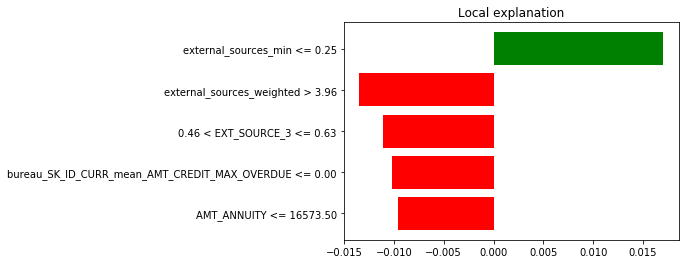

In [65]:
exp.as_pyplot_figure();